# Writing TIFF multilayer file readable from PhotoShop

The following example works:
* [Layered TIFF with psdtags](https://github.com/cgohlke/psdtags/blob/master/examples/layered_tiff.py)
In reply to the thread on StackOverflow:
* [Can't create a multilayer TIFF readable with PhotoShop with python libraries](https://stackoverflow.com/questions/79595242/cant-create-a-multilayer-tiff-readable-with-photoshop-with-python-libraries)

In [2]:
import tifffile
import numpy as np
import imagecodecs
import numpy
import tifffile
from psdtags import (
    PsdBlendMode,
    PsdChannel,
    PsdChannelId,
    PsdClippingType,
    PsdColorSpaceType,
    PsdCompressionType,
    PsdEmpty,
    PsdFilterMask,
    PsdFormat,
    PsdKey,
    PsdLayer,
    PsdLayerFlag,
    PsdLayerMask,
    PsdLayers,
    PsdRectangle,
    PsdString,
    PsdUserMask,
    TiffImageSourceData,
    __version__,
    overlay,
)

In [3]:
path = "../test/img-tif"
in_paths = [(path + "/000{:d}.tif".format(i)) for i in range(5)] + [path + "-stack/0001_pyr.tif"]
images = [tifffile.imread(p) for p in in_paths]
shape = images[0].shape[:2]

In [25]:
transp = np.full_like(images[0][..., 0], 65535)
fmt = 'Layer {:03d}'
layers = [PsdLayer(
    name=fmt.format(i + 1),
    rectangle=PsdRectangle(0, 0, *shape),
    channels=[
        PsdChannel(
            channelid=PsdChannelId.TRANSPARENCY_MASK,
            compression=PsdCompressionType.ZIP_PREDICTED,
            data=transp,
        ),
        PsdChannel(
            channelid=PsdChannelId.CHANNEL0,
            compression=PsdCompressionType.ZIP_PREDICTED,
            data=image[..., 0],
        ),
        PsdChannel(
            channelid=PsdChannelId.CHANNEL1,
            compression=PsdCompressionType.ZIP_PREDICTED,
            data=image[..., 1],
        ),
        PsdChannel(
            channelid=PsdChannelId.CHANNEL2,
            compression=PsdCompressionType.ZIP_PREDICTED,
            data=image[..., 2],
        ),
    ],
    mask=PsdLayerMask(),
    opacity=255,
    blendmode=PsdBlendMode.NORMAL,
    blending_ranges=(),
    clipping=PsdClippingType.BASE,
    flags=PsdLayerFlag.PHOTOSHOP5,
    info=[PsdString(PsdKey.UNICODE_LAYER_NAME, fmt.format(i + 1))],
) for i, image in enumerate (images)]

In [27]:
# create the ImageSourceData structure for the layered TIFF
image_source_data = TiffImageSourceData(
    name='Layered TIFF',
    psdformat=PsdFormat.LE32BIT,
    layers=PsdLayers(
        key=PsdKey.LAYER,
        has_transparency=False,
        layers=layers,
    ),
    usermask=PsdUserMask(
        colorspace=PsdColorSpaceType.RGB,
        components=(65535, 0, 0, 0),
        opacity=50,
    ),
    info=[
        PsdEmpty(PsdKey.PATTERNS),
        PsdFilterMask(
            colorspace=PsdColorSpaceType.RGB,
            components=(65535, 0, 0, 0),
            opacity=50,
        ),
    ],
)

In [29]:
tifffile.imwrite(
    'img-test/layered.tif',
    overlay(*((np.concatenate((image, np.expand_dims(transp, axis=-1)), axis=-1), (0, 0)) for image in images),
        shape=shape,
    ),
    photometric='rgb',
    compression='adobe_deflate',
    resolution=((720000, 10000), (720000, 10000)),
    resolutionunit='inch',
    metadata=None,
    extratags=[
        image_source_data.tifftag(maxworkers=4),
        (34675, 7, None, imagecodecs.cms_profile('srgb'), True),
    ],
)

In [30]:
print(f'psdtags {__version__}')
#isd = TiffImageSourceData.fromtiff('img-test/layered.tif')
#print(isd)
#for layer in isd.layers:
#    tifffile.imshow(layer.asarray(), title=layer.name)

psdtags 2025.1.1


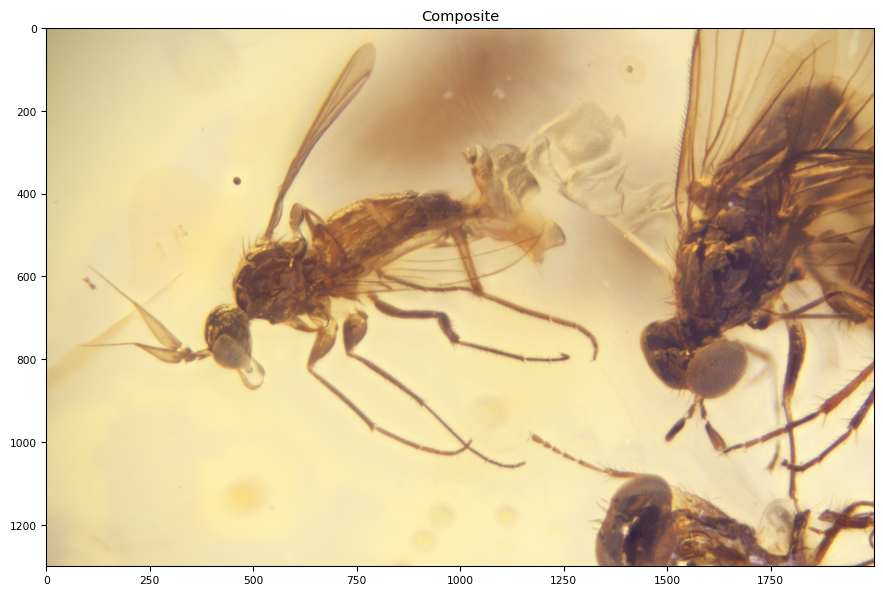

In [31]:
_ = tifffile.imshow(tifffile.imread('img-test/layered.tif'), title='Composite', show=True)